# Analysis 3

In this notebook we use the super reduced dst form the AB reducing process, in order to have fast energy reoslution analysis, with the advantage of being able to access to the isolated and non isolated hit without running the splitter again. 

In [ ]:
import os
import logging
import warnings

import numpy  as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from scipy.special import erf

from scipy.stats import linregress

from invisible_cities.io.dst_io               import load_dst, load_dsts
from krcal.NB_utils.fit_energy_functions      import fit_energy
from krcal.NB_utils.plt_energy_functions      import plot_fit_energy, print_fit_energy

from invisible_cities.reco import corrections

from invisible_cities.reco.corrections        import read_maps


In [65]:
def in_range(series, min_val, max_val):
    """Checks if values in a pandas Series are within a [min, max) range."""
    return (series >= min_val) & (series < max_val)


def gaus_with_linear_bg(x, amplitude, mu, sigma, slope, intercept):
    """A Gaussian peak with a sloped, linear background."""
    sigma = max(abs(sigma), 1e-9) # Failsafe for sigma
    gauss_part = amplitude * np.exp(-(x - mu)**2 / (2 * sigma**2))
    linear_part = slope * x + intercept
    return gauss_part + linear_part

def fit_peak_advanced(data, fit_model, mu_guess, fit_range, bins='freedman'):
    """
    An advanced fitting function that provides smarter initial guesses for
    a model with a linear background. Now with dynamic binning.
    """
    # --- Start of New Binning Logic ---
    subset_data = data[(data > fit_range[0]) & (data < fit_range[1])]

    if subset_data.empty:
        return None, None, (np.array([]), np.array([]))

    if isinstance(bins, str) and bins.lower() == 'freedman':
        q1 = subset_data.quantile(0.25)
        q3 = subset_data.quantile(0.75)
        iqr = q3 - q1
        if iqr > 0:
            bin_width = 2 * iqr * (len(subset_data) ** (-1/3))
            num_bins = int(np.ceil((fit_range[1] - fit_range[0]) / bin_width))
        else: # Fallback for data with no spread
            num_bins = 50 
    else:
        num_bins = int(bins)
    
    # Ensure a reasonable number of bins
    num_bins = np.clip(num_bins, 10, 200) 
    
    y, bin_edges = np.histogram(subset_data, bins=num_bins, range=fit_range)
    # --- End of New Binning Logic ---
    
    x = (bin_edges[:-1] + bin_edges[1:]) / 2

    if np.sum(y) < 20: return None, None, (x, y)

    edge_width = int(len(x) * 0.2) # Maybe use a slightly wider region
    if edge_width < 3: edge_width = 3

    bg_x = np.concatenate([x[:edge_width], x[-edge_width:]])
    bg_y = np.concatenate([y[:edge_width], y[-edge_width:]])

    # Only fit if there are enough points to define a line
    if len(bg_x) > 2:
        bg_fit = linregress(bg_x, bg_y)
        slope_guess = bg_fit.slope
        intercept_guess = bg_fit.intercept
    else: # Fallback to your old method if there are not enough points
        bg_y_left = np.mean(y[:edge_width]); bg_x_left = np.mean(x[:edge_width])
        bg_y_right = np.mean(y[-edge_width:]); bg_x_right = np.mean(x[-edge_width:])
        slope_guess = (bg_y_right - bg_y_left) / (bg_x_right - bg_x_left) if (bg_x_right - bg_x_left) > 1e-6 else 0
        intercept_guess = bg_y_left - slope_guess * bg_x_left
    
    background_at_peak = slope_guess * mu_guess + intercept_guess
    amplitude_guess = np.max(y) - background_at_peak
    if amplitude_guess < 0: amplitude_guess = np.max(y)

    
    peak_region_mask = (x > mu_guess - (fit_range[1]-fit_range[0])/5) & (x < mu_guess + (fit_range[1]-fit_range[0])/5)
    if np.any(peak_region_mask):
        y_subtracted = y[peak_region_mask] - (slope_guess * x[peak_region_mask] + intercept_guess)
        y_subtracted[y_subtracted < 0] = 0
        if np.sum(y_subtracted) > 0:
            sigma_guess = np.sqrt(np.average((x[peak_region_mask] - mu_guess)**2, weights=y_subtracted))
        else: sigma_guess = (fit_range[1] - fit_range[0]) / 10
    else: sigma_guess = (fit_range[1] - fit_range[0]) / 10
    
    if sigma_guess == 0: sigma_guess = (fit_range[1] - fit_range[0]) / 10


    # --- Model-Specific Guesses and Bounds ---
    if fit_model.__name__ == 'crystal_ball_with_linear_bg':
        # Guesses for Crystal Ball: [amplitude, mu, sigma, alpha, n, slope, intercept]
        alpha_guess = 1.5  # Typical starting point for the tail
        n_guess = 2.0      # Typical starting point for the tail exponent
        p0 = [amplitude_guess, mu_guess, sigma_guess, alpha_guess, n_guess, slope_guess, intercept_guess]
        bounds = ([0, fit_range[0], 0, 0.5, 1, -np.inf, -np.inf], 
                  [amplitude_guess*2, fit_range[1], sigma_guess*3, 5, 10, np.inf, np.inf])
    
    elif fit_model.__name__ == 'gaus_with_linear_bg':
        # Guesses for Gaussian: [amplitude, mu, sigma, slope, intercept]
        p0 = [amplitude_guess, mu_guess, sigma_guess, slope_guess, intercept_guess]
        bounds = ([0, fit_range[0], 0, -np.inf, -np.inf], 
                  [amplitude_guess*2, fit_range[1], sigma_guess*3, np.inf, np.inf])
    else:
        raise ValueError(f"Unknown fit model: {fit_model.__name__}")


    # --- Perform the Fit ---
    try:
        popt, pcov = curve_fit(fit_model, x, y, p0=p0, sigma=np.sqrt(np.maximum(y, 1)), absolute_sigma=True, bounds=bounds, maxfev=5000)
        return popt, pcov, (x, y)
    except (RuntimeError, ValueError) as e:
        print(f"  - Fit failed for peak near {mu_guess:.2f} MeV with {fit_model.__name__}. Reason: {e}")
        return None, None, (x, y)

    #p0 = [amplitude_guess, mu_guess, sigma_guess, slope_guess, intercept_guess]

    #try:
    #    popt, pcov = curve_fit(fit_model, x, y, p0=p0, sigma=np.sqrt(np.maximum(y, 1)), absolute_sigma=True)
    #    return popt, pcov, (x, y)
    #except (RuntimeError, ValueError) as e:
    #    print(f"  - Fit failed for peak near {mu_guess:.2f} MeV. Reason: {e}")
    #    return None, None, (x, y)
    

def crystal_ball_with_linear_bg(x, amplitude, mu, sigma, alpha, n, slope, intercept):
    """
    A Crystal Ball peak shape with a sloped, linear background.
    - alpha: The point where the tail begins (in units of sigma).
    - n: The power-law exponent of the tail.
    """
    sigma = max(abs(sigma), 1e-9)

    # Calculate the Crystal Ball function
    t = (x - mu) / sigma

    # Condition for the power-law tail
    is_tail = t < -abs(alpha)

    # Gaussian part
    A = (n / abs(alpha))**n * np.exp(-abs(alpha)**2 / 2)
    B = n / abs(alpha) - abs(alpha)

    cb_vals = np.where(
        is_tail,
        A * (B - t)**(-n),          # Power-law tail
        np.exp(-0.5 * t**2)         # Gaussian core
    )

    peak_part = amplitude * cb_vals
    linear_part = slope * x + intercept

    return peak_part + linear_part

load cleaned data

In [81]:
#run_ids = [15589, 15590, 15591, 15593, 15594, 15596]
run_ids = [15589]
base_path = "/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE"

kdst_key = "FinalFeatures"
all_dfs = []

for run_id in run_ids:
    kdst_input_glob = f"{base_path}/{run_id}/sophronia/final_dst/*final_features_v2.h5"
    kdst_files = sorted(glob.glob(kdst_input_glob))
    if not kdst_files:
        raise FileNotFoundError(f"No kDST files found at: {kdst_input_glob}")
    
    print(f"Found {len(kdst_files)} files for run {run_id}")
    all_dfs.extend(pd.read_hdf(path, key=kdst_key) for path in kdst_files)

full_fil_df = pd.concat(all_dfs, ignore_index=True)


print(f"Loaded {full_fil_df['event'].nunique()} unique events from kDSTs.")
full_fil_df = full_fil_df[full_fil_df.E_final > 0]
full_fil_df = full_fil_df[full_fil_df.DT > 0]
full_fil_df = full_fil_df[in_range(full_fil_df.Rmax, 0, 450)]
full_fil_df = full_fil_df[
    in_range(full_fil_df.Zmin, 20, 1184.185) & 
    in_range(full_fil_df.Zmax, 20, 1184.185)
]

print(f"Loaded {full_fil_df['event'].nunique()} unique events from kDSTs.")

Found 7 files for run 15589
Loaded 346353 unique events from kDSTs.
Loaded 206055 unique events from kDSTs.


In [82]:
full_fil_df.E_final

1         365589.157864
5          68365.078801
8         353169.155115
10         73532.351414
12        148400.885190
              ...      
346348    379719.600085
346349     82997.857452
346350     69793.588749
346351     85688.944477
346352    151251.005302
Name: E_final, Length: 206055, dtype: float64

In [20]:
kdst_input_glob = "/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/15590/sophronia/filtered_kdst/*.h5"
kdst_files = sorted(glob.glob(kdst_input_glob))
if not kdst_files: raise FileNotFoundError(f"No kDST files found at: {kdst_input_glob}")
kdst_key = 'DST/Events'
dff = [pd.read_hdf(path, key=kdst_key) for path in kdst_files]
full_fil_df = pd.concat(dff, ignore_index=True)
print(f"Loaded {full_fil_df['event'].nunique()} unique events from kDSTs.")

Loaded 958251 unique events from kDSTs.


In [72]:
full_fil_df

,event,time,S1w,S1h,S1e,S1t,S2w,S2h,S2e,S2q,...,Y_bary,Z_bary,Xmax_final,Ymax_final,Zmax_final,Xmin_final,Ymin_final,Zmin_final,Rmax_final,Zdiff_final
0,29,1.751990e+09,650.0,70.675652,391.903259,604150.0,510.125,4855.565430,284933.000000,118341.734375,...,-394.267280,831.755059,227.675,-247.675,965.458500,10.975,-479.925,754.268250,336.420587,211.190250
1,120,1.751990e+09,675.0,56.735172,335.559998,790500.0,325.700,5438.912598,347422.250000,104431.320312,...,-140.575041,663.460993,381.175,13.675,753.129250,-19.125,-263.725,589.597375,381.420223,163.531875
3,358,1.751990e+09,275.0,10.520331,60.535091,1199650.0,110.100,6464.333008,77638.617188,23629.761719,...,-247.208627,207.092947,-220.275,-185.975,222.787125,-359.225,-324.925,195.925000,288.284194,26.862125
5,442,1.751990e+09,525.0,13.394168,74.863655,497525.0,216.350,3785.974609,67065.500000,37907.949219,...,43.714905,912.947330,196.575,91.425,961.278000,88.725,-16.425,897.871625,216.795436,63.406375
6,477,1.751990e+09,325.0,63.131920,329.377167,993900.0,364.525,5553.118652,332835.843750,102656.492188,...,-298.084631,475.716768,366.625,-202.025,582.643875,-19.125,-386.625,383.600000,418.602426,199.043875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850384,3815385,1.752588e+09,150.0,0.679896,3.209712,1295250.0,19.925,786.257751,7723.065430,751.256714,...,-64.831959,111.191722,288.875,-31.975,119.583250,227.675,-93.675,103.879000,290.639237,15.704250
1850385,3815462,1.752588e+09,200.0,1.629532,7.870398,786150.0,27.425,1124.805420,12533.636719,1036.058594,...,237.500244,619.079347,319.975,276.525,626.690625,243.225,214.325,610.912750,422.906699,15.777875
1850386,3815826,1.752588e+09,150.0,3.278501,12.182398,682700.0,27.650,874.126648,10273.219727,726.658020,...,-147.883997,723.120306,273.325,-109.725,729.195500,212.125,-171.425,715.359000,294.526962,13.836500
1850387,3815917,1.752588e+09,275.0,2.669423,13.197507,768650.0,25.425,760.963684,9073.124023,689.883301,...,72.642232,635.048130,381.175,106.475,641.270375,319.975,45.275,627.416125,395.766732,13.854250


In [4]:
full_fil_df.columns

Index(['event', 'time', 'S1w', 'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q',
       'S2t', 'qmax', 'DT', 'R', 'npeaks_count', 'E_final', 'Rmax', 'Zmax',
       'Zmin', 'E_final_time', 'Q_final', 'hits_final', 'X_bary', 'Y_bary',
       'Z_bary', 'Xmax_final', 'Ymax_final', 'Zmax_final', 'Xmin_final',
       'Ymin_final', 'Zmin_final', 'Rmax_final', 'Zdiff_final'],
      dtype='object')

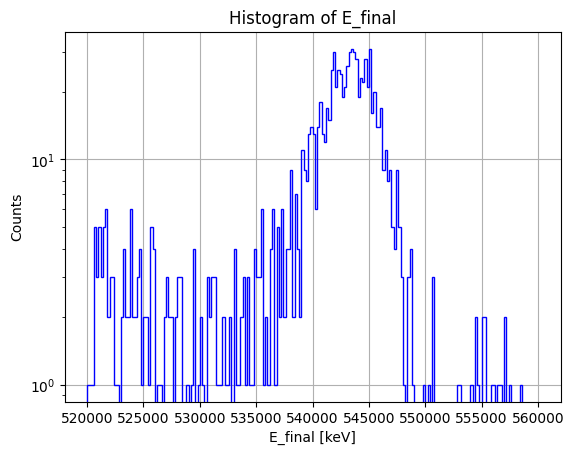

In [118]:
#doa  histogram of full_fil_df.E_final
plt.hist(full_fil_df.E_final, bins=200, range=(520000, 560000), histtype='step', color='blue')
plt.yscale('log')
plt.xlabel('E_final [keV]')
plt.ylabel('Counts')
plt.title('Histogram of E_final')
plt.grid(True)
plt.show()

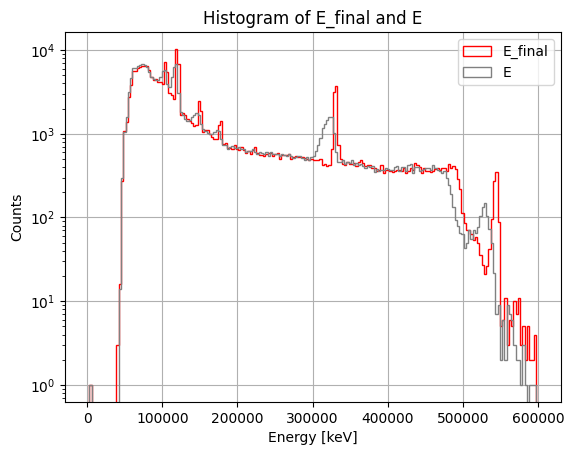

In [91]:
#doa  histogram of full_fil_df.E_final and full_fil_df.E
plt.hist(full_fil_df.E_final, bins=200, range=(0, 600000), histtype='step', color='red', label='E_final')
plt.hist(full_fil_df.S2e, bins=200, range=(0, 600000), histtype='step', color='grey', label='E')
plt.yscale('log')
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
plt.title('Histogram of E_final and E')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
known_peaks = {
            "511 keV":   {'real': 107537, 'guess': 110484, 'range': (105223, 115745)},
            "583 keV":   {'real': 122690, 'guess': 126267, 'range': (121006, 130476)},
            "727 keV":   {'real': 152994, 'guess': 157834, 'range': (153625, 162043)},
            "860 keV":   {'real': 180983, 'guess': 187296, 'range': (180983, 191505)},
            "DE Peak":   {'real': 335029, 'guess': 347234, 'range': (343026, 353548)},
            "Tl Peak":   {'real': 550314, 'guess': 572411, 'range': (566097, 578724)}
}

In [ ]:
known_peaks = {
            "511 keV":   {'real': 0.511,  'guess': 0.525,  'range': (0.50, 0.55)},
            "583 keV":   {'real': 0.583,  'guess': 0.60,  'range': (0.575, 0.62)},
            "727 keV":   {'real': 0.727,  'guess': 0.75,  'range': (0.73, 0.77)},
            "860 keV":   {'real': 0.860,  'guess': 0.89,  'range': (0.86, 0.91)},
            "DE Peak":   {'real': 1.592,  'guess': 1.65,   'range': (1.63, 1.68)},
            "Tl Peak":   {'real': 2.615,  'guess': 2.72,   'range': (2.69, 2.75)}
        }

In [8]:
known_peaks = {
            "511 keV":   {'real': 0.511,  'guess': 0.51,  'range': (0.48, 0.53)},
            "583 keV":   {'real': 0.583,  'guess': 0.58,  'range': (0.555, 0.60)},
            "727 keV":   {'real': 0.727,  'guess': 0.72,  'range': (0.70, 0.75)},
            "860 keV":   {'real': 0.860,  'guess': 0.86,  'range': (0.83, 0.88)},
            "DE Peak":   {'real': 1.592,  'guess': 1.6,   'range': (1.58, 1.645)},
            "Tl Peak":   {'real': 2.615,  'guess': 2.61,   'range': (2.59, 2.72)}
        }


==================== Running ADVANCED Calibration & Resolution

Stage 1: Performing initial fits...


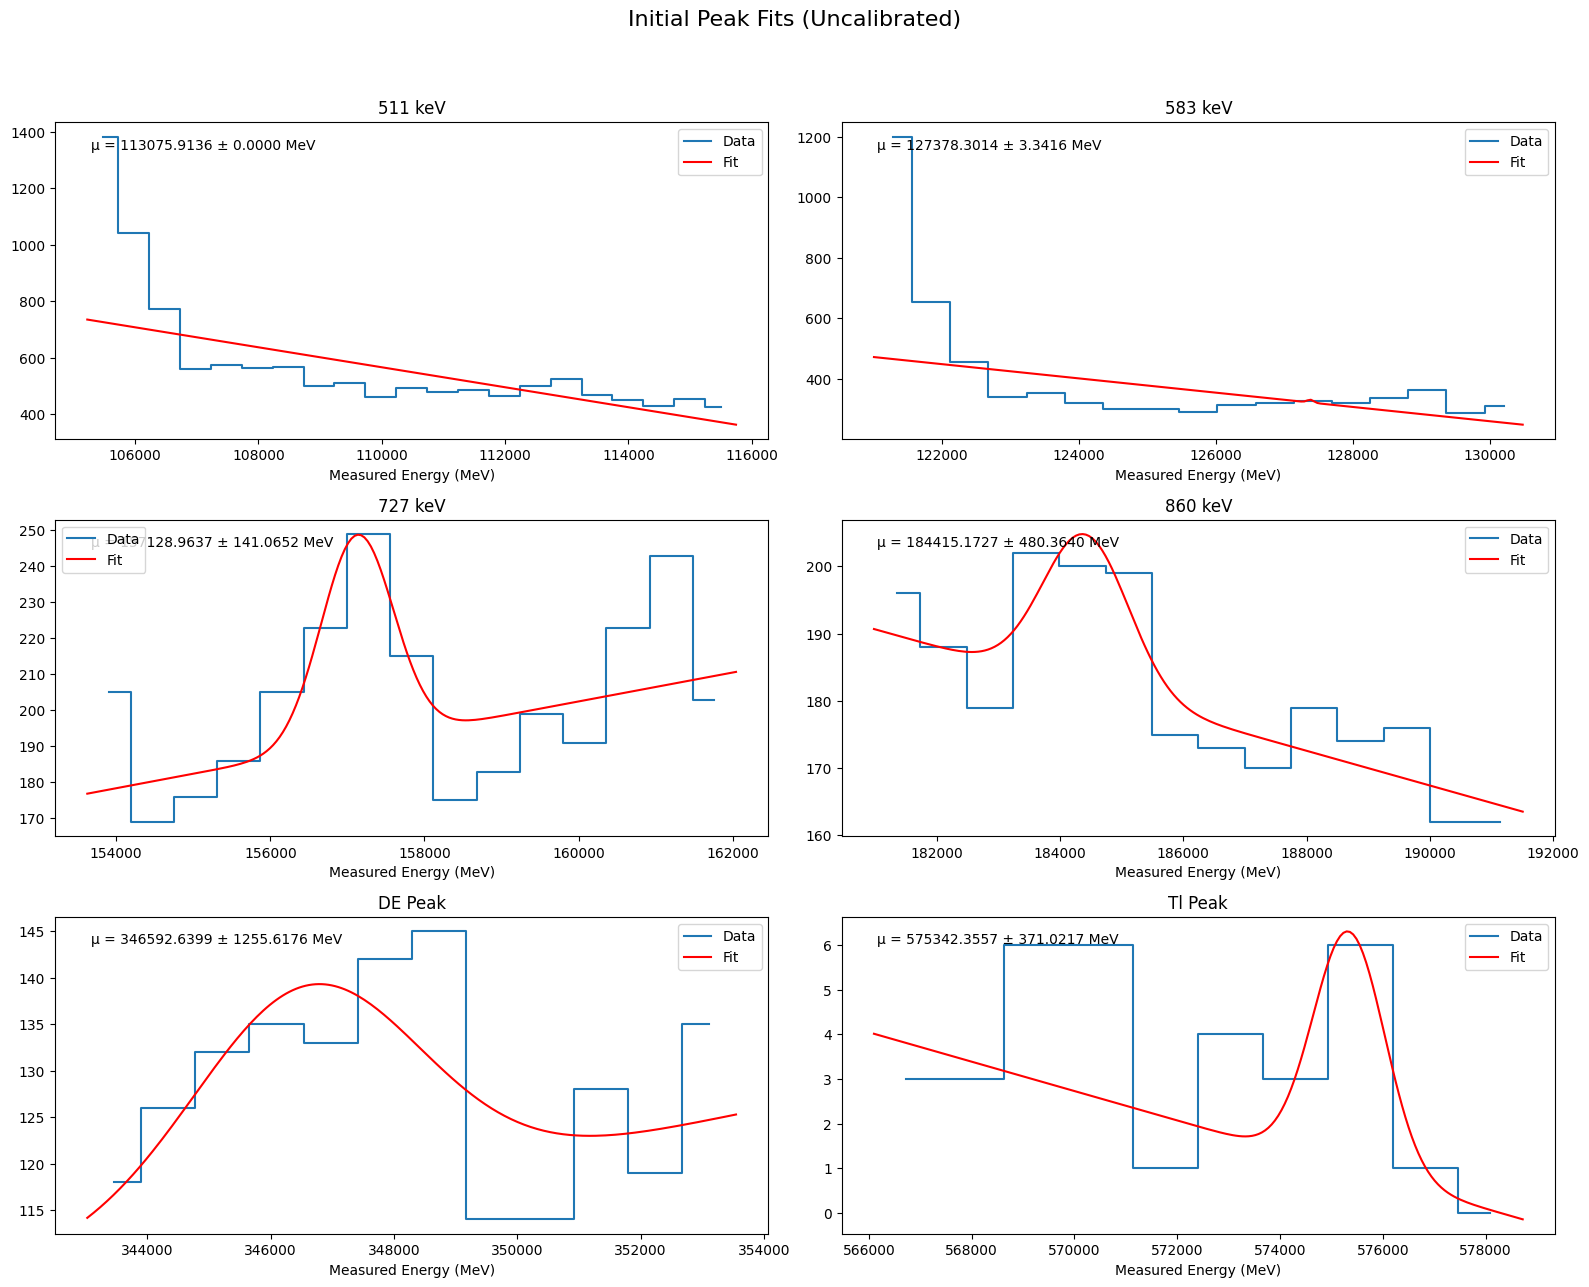


Initial Fit Parameters:


,name,real_E,measured_E,measured_E_err
0,511 keV,107537,113075.913646,1.509093e-08
1,583 keV,122690,127378.301434,3.341616e+00
2,727 keV,152994,157128.963660,1.410652e+02
3,860 keV,180983,184415.172740,4.803640e+02
4,DE Peak,335029,346592.639926,1.255618e+03
5,Tl Peak,550314,575342.355650,3.710217e+02



Stage 2: Calibration found: E_shifted = 0.95502 * E_measured + 2210.17451


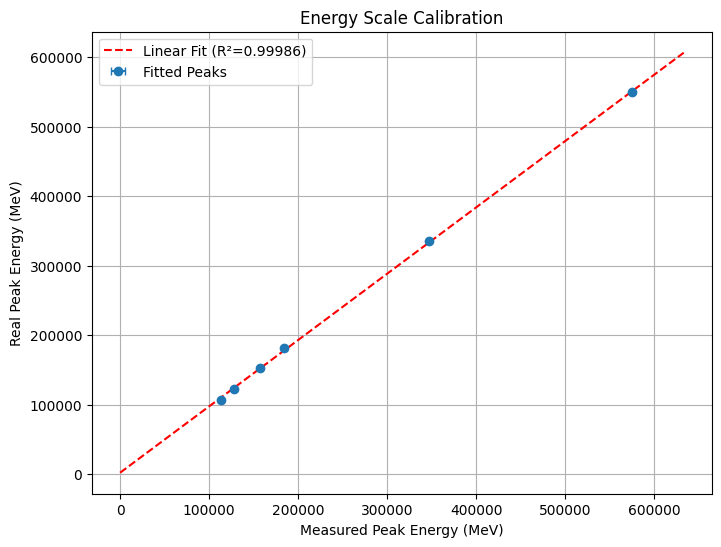

/tmp/villamil/ipykernel_1999389/2847061671.py:56: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_final_spec.set_title(f'Final Calibrated Spectrum'); ax_final_spec.set_xlabel('Energy (MeV)'); ax_final_spec.set_ylabel('Counts'); ax_final_spec.set_yscale('log'); ax_final_spec.legend()


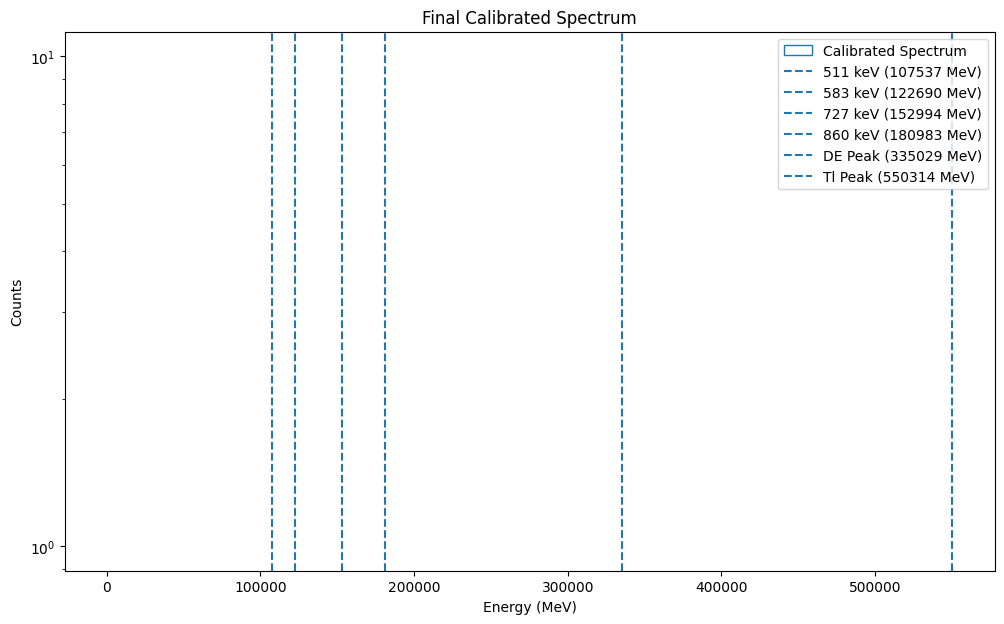


Stage 4: Calculating final energy resolution...


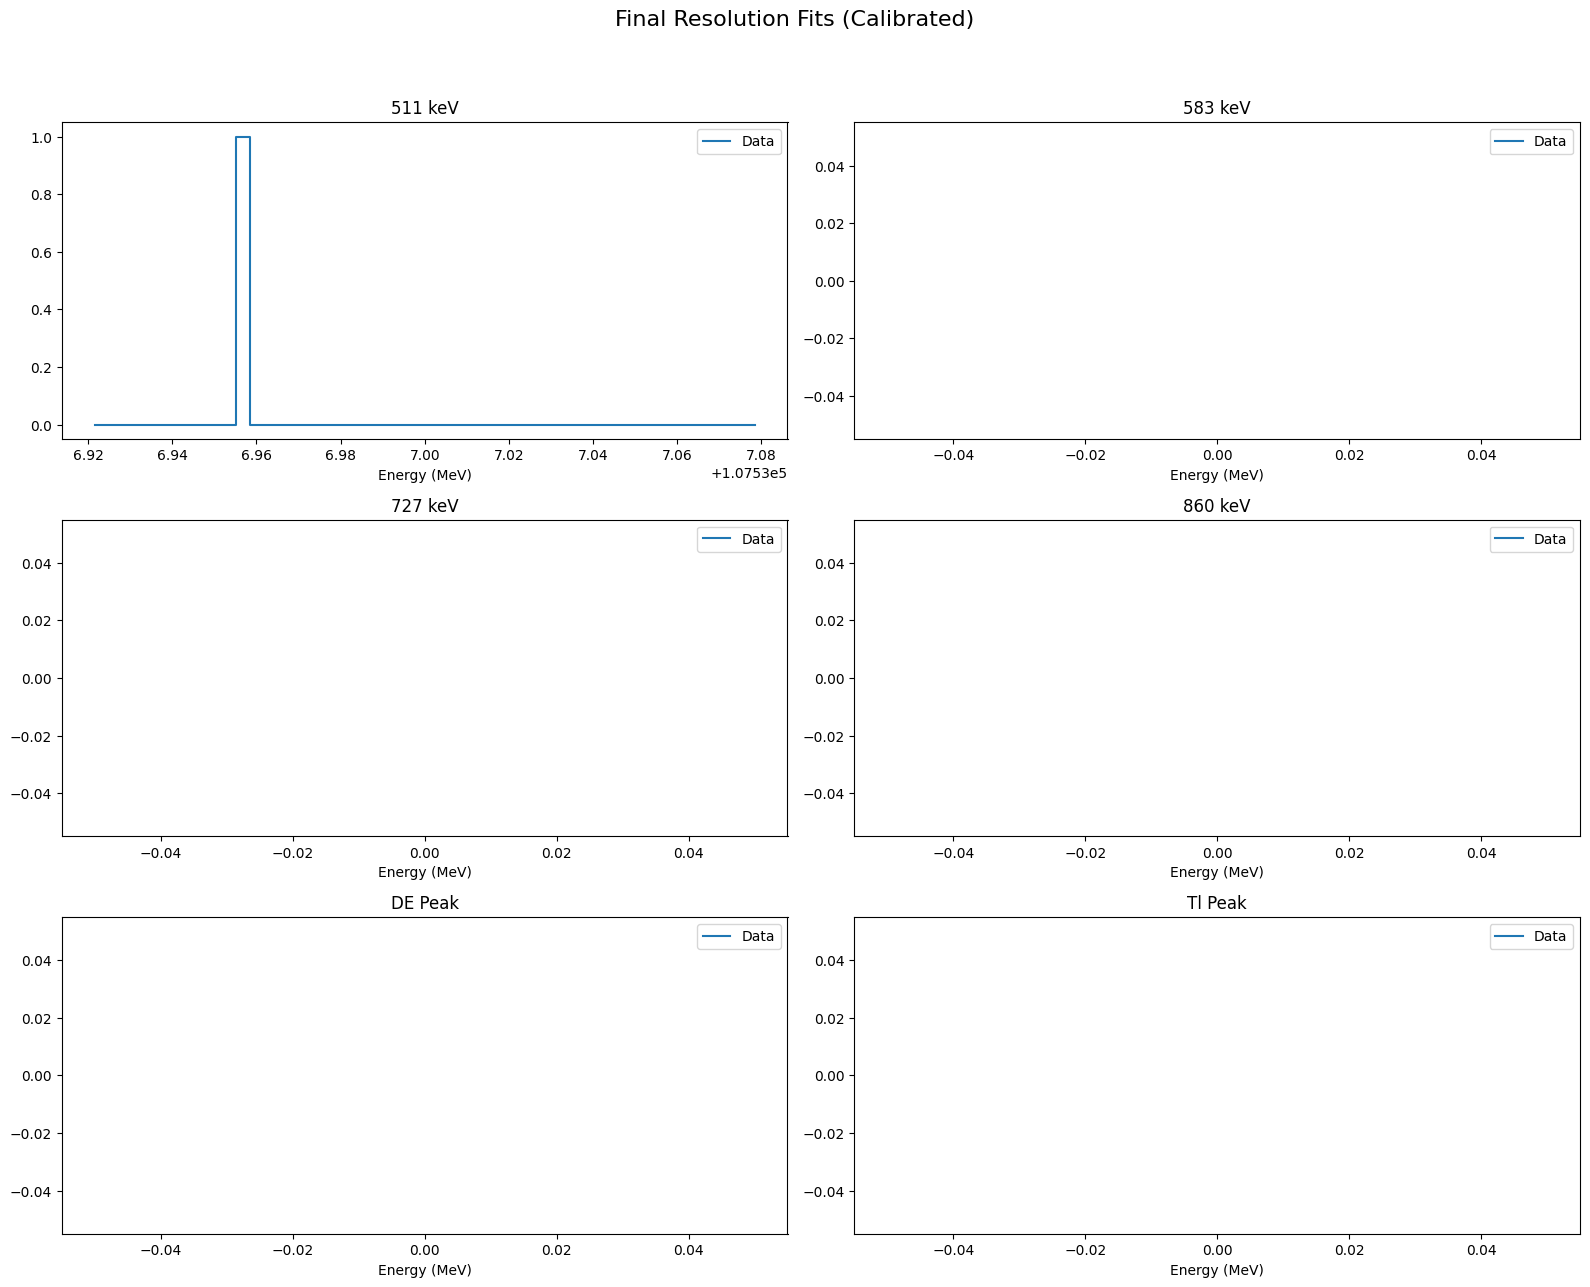

In [84]:
print(f"\n{'='*20} Running ADVANCED Calibration & Resolution")

dst_full = full_fil_df.copy()

initial_energies = dst_full['E_final']

# --- Stage 1: Initial Fits ---
print("\nStage 1: Performing initial fits...")
initial_fit_results = []
n_peaks = len(known_peaks)
fig_init, axes_init = plt.subplots(int(np.ceil(n_peaks/2)), 2, figsize=(16, 4.5 * np.ceil(n_peaks/2)))
axes_init = axes_init.flatten()
fig_init.suptitle(f'Initial Peak Fits (Uncalibrated)', fontsize=16)

for i, (peak_name, props) in enumerate(known_peaks.items()):
    ax = axes_init[i]
    num_bins = props.get('bins', 60)
    popt, pcov, hist_data = fit_peak_advanced(initial_energies, gaus_with_linear_bg, props['guess'], props['range'], bins='freedman')
    
    ax.step(hist_data[0], hist_data[1], where='mid', label='Data')
    if popt is not None:
        fit_x = np.linspace(props['range'][0], props['range'][1], 200)
        ax.plot(fit_x, gaus_with_linear_bg(fit_x, *popt), 'r-', label='Fit')
        mu, mu_err = popt[1], np.sqrt(pcov[1, 1])
        initial_fit_results.append({'name': peak_name, 'real_E': props['real'], 'measured_E': mu, 'measured_E_err': mu_err})
        ax.text(0.05, 0.95, f'μ = {mu:.4f} ± {mu_err:.4f} MeV', transform=ax.transAxes, va='top')
    ax.set_title(peak_name); ax.set_xlabel('Measured Energy (MeV)'); ax.legend()

fig_init.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show() # Display the initial fits plot

# --- Stage 2: Linear Calibration Fit ---
fit_df = pd.DataFrame(initial_fit_results)
if len(fit_df) < 2:
    print("  - Not enough successful fits to perform calibration. Aborting for this workflow.")
else:
    print("\nInitial Fit Parameters:")
    display(fit_df) # Display the initial fit parameters dataframe

    calib_fit = linregress(fit_df['measured_E'], fit_df['real_E'])
    m, n = calib_fit.slope, calib_fit.intercept
    print(f"\nStage 2: Calibration found: E_shifted = {m:.5f} * E_measured + {n:.5f}")

    fig_calib, ax_calib = plt.subplots(figsize=(8, 6))
    ax_calib.errorbar(fit_df['measured_E'], fit_df['real_E'], xerr=fit_df['measured_E_err'], fmt='o', capsize=3, label='Fitted Peaks')
    x_fit = np.array([0, fit_df['measured_E'].max() * 1.1]); y_fit = m * x_fit + n
    ax_calib.plot(x_fit, y_fit, 'r--', label=f'Linear Fit (R²={calib_fit.rvalue**2:.5f})'); ax_calib.set_title('Energy Scale Calibration'); ax_calib.set_xlabel('Measured Peak Energy (MeV)'); ax_calib.set_ylabel('Real Peak Energy (MeV)'); ax_calib.legend(); ax_calib.grid(True)
    plt.show() # Display the calibration plot

    # --- Stage 3: Apply Calibration and Plot Final Spectrum ---
    calibrated_energies = m * initial_energies + n
    fig_final_spec, ax_final_spec = plt.subplots(figsize=(12, 7))
    ax_final_spec.hist(calibrated_energies, bins=int(3.0/0.01), range=(0, 3.0), histtype='step', label=f'Calibrated Spectrum')
    for peak_name, props in known_peaks.items():
        ax_final_spec.axvline(props['real'], linestyle='--', label=f"{peak_name} ({props['real']} MeV)")
    ax_final_spec.set_title(f'Final Calibrated Spectrum'); ax_final_spec.set_xlabel('Energy (MeV)'); ax_final_spec.set_ylabel('Counts'); ax_final_spec.set_yscale('log'); ax_final_spec.legend()
    plt.show() # Display the final spectrum plot

    # --- Stage 4: Final Resolution Fits ---
    print("\nStage 4: Calculating final energy resolution...")
    final_resolution_results = []
    fig_final_fits, axes_final_fits = plt.subplots(int(np.ceil(n_peaks/2)), 2, figsize=(16, 4.5 * np.ceil(n_peaks/2)))
    axes_final_fits = axes_final_fits.flatten()
    fig_final_fits.suptitle(f'Final Resolution Fits (Calibrated)', fontsize=16)

    for i, (peak_name, props) in enumerate(known_peaks.items()):
        ax = axes_final_fits[i]
        calib_range = (props['real'] - 0.08, props['real'] + 0.08) 
        #num_bins = props.get('bins', 80)
        popt, pcov, hist_data = fit_peak_advanced(calibrated_energies, crystal_ball_with_linear_bg, props['real'], calib_range, bins='freedman')
        
        ax.step(hist_data[0], hist_data[1], where='mid', label='Data')
        if popt is not None:
            fit_x = np.linspace(calib_range[0], calib_range[1], 200)
            # --- Make sure to use the correct model when plotting the fit line ---
            ax.plot(fit_x, crystal_ball_with_linear_bg(fit_x, *popt), 'r-', label='Crystal Ball Fit')
            #ax.plot(fit_x, gaus_with_linear_bg(fit_x, *popt), 'r-', label='Fit')
            mu, sigma = popt[1], abs(popt[2])
            mu_err, sigma_err = np.sqrt(pcov[1, 1]), np.sqrt(pcov[2, 2])
            resolution = 2.355 * sigma / mu * 100
            res_err = resolution * np.sqrt((sigma_err/sigma)**2 + (mu_err/mu)**2) if sigma > 0 and mu > 0 else np.nan
            final_resolution_results.append({'peak': peak_name, 'energy_MeV': props['real'], 'resolution_fwhm_percent': resolution, 'resolution_error': res_err})
            ax.text(0.05, 0.95, f'μ = {mu:.4f} ± {mu_err:.4f} MeV\nR(%) = {resolution:.2f} ± {res_err:.2f}', transform=ax.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.set_title(peak_name); ax.set_xlabel('Energy (MeV)'); ax.legend()

    fig_final_fits.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show() # Display the final fits plot

    # Create and display the final results dataframe
    final_results_df = pd.DataFrame(final_resolution_results)

    if not final_results_df.empty:
        print(f"\nFinal Resolution Results:")
        display(final_results_df) # Display the final results dataframe

    # The final_results_df is now available for further use in the notebook.
    # If this code was part of a function, you would still use:
    # return final_results_df

# Check the time evolution map corrections

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import savgol_filter # For smoothing

def visualize_time_correction_map(
    csv_path: str,
    run_info: dict = None, # Optional: Dictionary mapping run numbers to start/end times
    time_bin_width_hours: int = 8
):
    """
    Loads and plots the contents of a time correction map to visually inspect
    the detector's stability over time.

    Args:
        csv_path (str): The full path to your time_correction_map.csv file.
        run_info (dict, optional): A dictionary to label different run periods.
                                   Example: {15589: ('2025-07-08', '2025-07-09'), ...}
    """
    print(f"--- Visualizing Time Correction Map (v2) for {time_bin_width_hours}hr bins ---")
    
    time_corr_df = pd.read_csv(csv_path)
    # Ensure it's sorted by time
    time_corr_df.sort_values('start_time', inplace=True)

    time_corr_df['datetime'] = pd.to_datetime((time_corr_df['start_time'] + time_corr_df['end_time']) / 2, unit='s')
    
    # --- IMPROVEMENT 1: Use the overall mean as the reference ---
    reference_kr_energy = time_corr_df['kr_peak_E'].mean()
    print(f"  - Using STABLE reference Kr energy (overall mean): {reference_kr_energy:.4f} MeV")
    
    # --- IMPROVEMENT 2: Apply smoothing ---
    # Savitzky-Golay filter needs a window length (must be odd) and polynomial order.
    # A window of 5 and order of 2 is a good starting point.
    window_length = 5
    poly_order = 2
    if len(time_corr_df) >= window_length:
        print(f"  - Applying Savitzky-Golay smoothing filter (window={window_length}, order={poly_order})...")
        time_corr_df['kr_peak_E_smoothed'] = savgol_filter(
            time_corr_df['kr_peak_E'], window_length, poly_order
        )
    else:
        print("  - Not enough data points to apply smoothing. Using raw values.")
        time_corr_df['kr_peak_E_smoothed'] = time_corr_df['kr_peak_E']

    # --- Calculate the correction factor using the SMOOTHED values ---
    time_corr_df['time_corr_factor'] = reference_kr_energy / time_corr_df['kr_peak_E_smoothed']
    
    # --- Plotting ---
    fig, ax1 = plt.subplots(figsize=(15, 7))
    fig.suptitle('Time Evolution of Measured Krypton Peak (with Smoothing)', fontsize=16)

    # Plot Measured Kr Peak
    ax1.errorbar(time_corr_df['datetime'], time_corr_df['kr_peak_E'], yerr=time_corr_df['kr_peak_err'],
                 fmt='o', capsize=4, color='lightblue', label='Measured Kr Peak (Raw)')
    
    # Plot Smoothed Kr Peak
    ax1.plot(time_corr_df['datetime'], time_corr_df['kr_peak_E_smoothed'], 'o-', color='tab:blue', label='Smoothed Kr Peak')
    
    # Set a reference line for the starting energy
    ax1.axhline(reference_kr_energy, color='grey', linestyle='--', label=f'Reference E = {reference_kr_energy:.4f} MeV')
    ax1.legend(loc='upper left')

    # --- Plot 2: Time Correction Factor (Right Y-axis) ---
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('Time Correction Factor N(t)', color=color2)
    ax2.plot(
        time_corr_df['datetime'],
        time_corr_df['time_corr_factor'],
        's--',
        color=color2,
        label='Correction Factor N(t)'
    )
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.legend(loc='upper right')

    # --- Formatting the Time Axis ---
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    fig.autofmt_xdate() # Rotate date labels for readability
    
    # --- Optional: Highlight different run periods ---
    if run_info:
        colors = plt.cm.get_cmap('Pastel1', len(run_info))
        for i, (run_id, (start, end)) in enumerate(run_info.items()):
            ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end),
                        facecolor=colors(i), alpha=0.3, label=f'Run {run_id}')
        # Re-create legends to include the new labels
        ax1.legend(loc='upper left')

    plt.show()

--- Visualizing Time Correction Map (v2) for 8hr bins ---
  - Using STABLE reference Kr energy (overall mean): 0.0416 MeV
  - Applying Savitzky-Golay smoothing filter (window=5, order=2)...


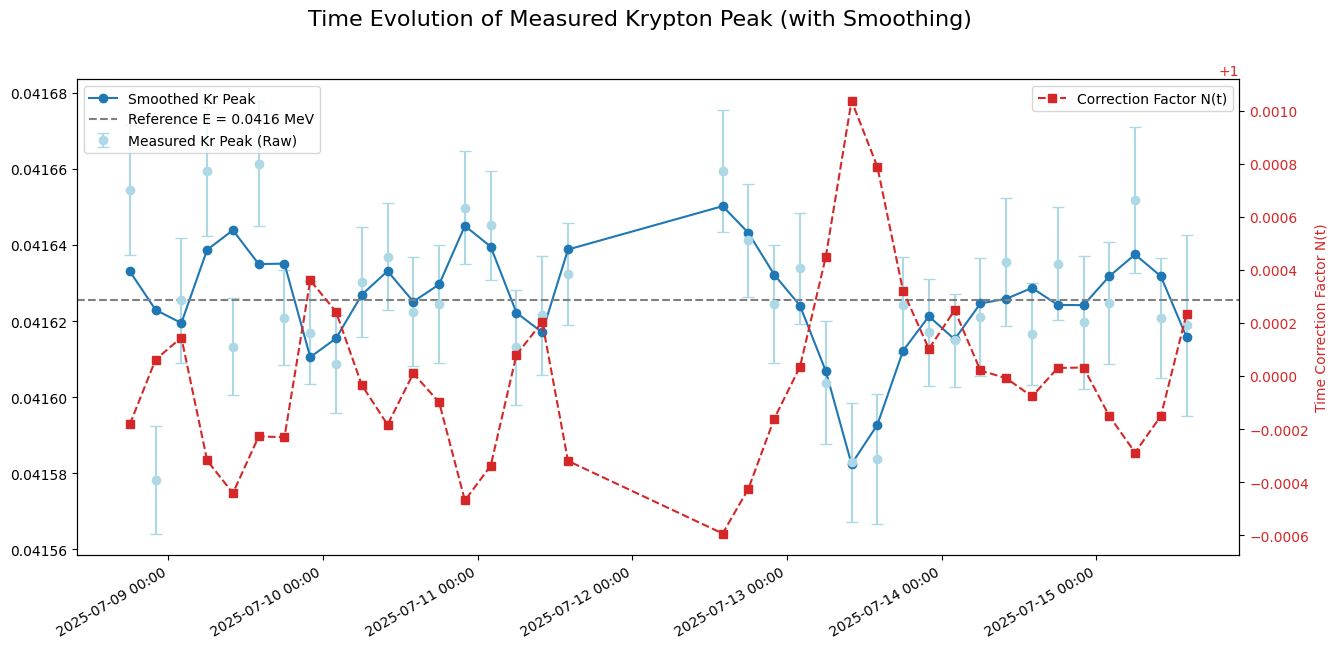

In [14]:
time_map_path = "/lhome/ific/v/villamil/kr_next100/time_correction_map_runs_full.csv"

# (Optional) Define the time ranges for your runs to add context
# run_date_ranges = {
#     15589: ('2025-07-08', '2025-07-09'),
#     15590: ('2025-07-09', '2025-07-10'),
#     # ... add other runs
# }

# Call the visualization function
visualize_time_correction_map(time_map_path)

In [43]:
from scipy.interpolate import interp1d
from scipy.interpolate import griddata

def get_corr3d(fname):
    krmap = pd.read_hdf(fname, "/krmap")
    meta  = pd.read_hdf(fname, "/mapmeta")
    dtxy_map   = krmap.loc[:, list("zxy")].values
    factor_map = krmap.factor.values
    def corr(dt, x, y, method="nearest"):
        dtxy_data   = np.stack([dt, x, y], axis=1)
        factor_data = griddata(dtxy_map, factor_map, dtxy_data, method=method)
        return factor_data
    return corr

map_file_path = f"/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/combined_15546_15557.map3d"
corr3d = get_corr3d(map_file_path)

In [63]:
run_id = 15590
kdst_input_glob = f"/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/15589/sophronia/clean_df/run_15589_ldc1_clean.h5"
kdst_files = sorted(glob.glob(kdst_input_glob))
if not kdst_files: raise FileNotFoundError(f"No kDST files found at: {kdst_input_glob}")
kdst_key = 'RECO/Events'
dff = [pd.read_hdf(path, key=kdst_key) for path in kdst_files]
full_fil_df = pd.concat(dff, ignore_index=True)
print(f"Loaded {full_fil_df['event'].nunique()} unique events from kDSTs.")

Loaded 49651 unique events from kDSTs.


In [49]:
from  invisible_cities.reco.corrections     import read_maps, apply_all_correction
map_file_path = f"/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/15589/map/run_15589.v2.3.1.20250717.Kr.map.h5"
maps = read_maps(map_file_path)
corr_func = apply_all_correction(maps, apply_temp=False) 


In [57]:
full_fil_df

,event,time,npeak,X,Y,Z,Q,Ec,E_corr,is_isolated,E
0,167,1.751990e+09,36,-373.775,-279.275,659.676875,7.792255,-0.000053,-0.000000,True,-6.949291
1,167,1.751990e+09,36,443.375,-232.625,672.480375,8.649711,NaN,0.000000,True,118.573701
2,167,1.751990e+09,36,-328.125,122.025,676.147375,7.395261,0.004127,820.226971,True,755.735124
3,167,1.751990e+09,36,57.625,322.675,680.096500,11.216484,0.001817,359.824667,False,338.180351
4,167,1.751990e+09,36,57.625,338.225,680.096500,10.344442,0.001679,331.948054,False,311.888033
...,...,...,...,...,...,...,...,...,...,...,...
36041411,3847185,1.752077e+09,25,-404.875,-140.325,89.229750,7.217733,0.002644,530.991297,True,458.717342
36041412,3847185,1.752077e+09,25,-173.625,-417.725,105.235625,7.215861,0.000927,181.508452,True,138.387163
36041413,3847185,1.752077e+09,25,-142.525,-278.775,105.235625,7.076700,0.000716,144.348874,True,135.718314
36041414,3847185,1.752077e+09,25,-158.075,-371.075,136.385125,7.178027,0.000458,92.202313,True,79.306397


In [54]:
corr_factors = corr3d(full_fil_df.Z, full_fil_df.X, full_fil_df.Y)

In [51]:
corr_factors = corr_func(full_fil_df.X, full_fil_df.Y, full_fil_df.Z, full_fil_df.time)

In [55]:
corr_factors
#how many values are different from zero
nonzero=np.count_nonzero(corr_factors)
print(f"Non-zero correction factors: {nonzero} out of {len(corr_factors)} ({nonzero/len(corr_factors)*100:.2f}%)")
#and how many are zero
zzeros=np.count_nonzero(corr_factors==0)
print(f"Zero correction factors: {zzeros} out of {len(corr_factors)} ({zzeros/len(corr_factors)*100:.2f}%)")
#also check how many are nan
nans=np.count_nonzero(np.isnan(corr_factors))
print(f"NaN correction factors: {nans} out of {len(corr_factors)} ({nans/len(corr_factors)*100:.2f}%)")



Non-zero correction factors: 34912397 out of 36041416 (96.87%)
Zero correction factors: 1129019 out of 36041416 (3.13%)
NaN correction factors: 0 out of 36041416 (0.00%)


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def visualize_correction_map(map_file_path, events_column_name='nevents_in_bin'):
    """
    Loads a 3D correction map and visualizes the number of events
    in a 2D projection.

    Args:
        map_file_path (str): The full path to the .map3d HDF5 file.
        events_column_name (str): The name of the column containing the number
                                  of events for each bin. This may need to be
                                  adjusted based on the actual file contents.
    """
    try:
        # Load the main data from the HDF5 file
        krmap = pd.read_hdf(map_file_path, "/krmap")
        print("Successfully loaded the '/krmap' dataset.")
        print("\nDataFrame Head:")
        print(krmap.head())
        print("\nDataFrame Columns:")
        print(krmap.columns)

    except Exception as e:
        print(f"Error loading the HDF5 file: {e}")
        print("Please ensure the file path is correct and the '/krmap' dataset exists.")
        return

    # --- Data Plausibility Check ---
    required_columns = ['x', 'y', 'z', events_column_name]
    if not all(col in krmap.columns for col in required_columns):
        print(f"\n--- ATTENTION ---")
        print(f"One or more required columns ('x', 'y', 'z', '{events_column_name}') were not found.")
        print("Please check the printed column list above and modify the 'events_column_name' variable")
        print("in the script to match the actual column name for event counts (e.g., 'entries', 'counts', etc.).")
        return

    # --- Create the 2D XY Projection ---
    # We pivot the table to create a 2D grid of X vs Y.
    # Since there are multiple Z values for each (X,Y) pair, we sum the
    # number of events over all Z bins to get the total events in each XY column.
    print("\nCreating 2D projection by summing events over the Z-axis...")
    xy_events_map = krmap.pivot_table(index='y', columns='x', values=events_column_name, aggfunc='sum')

    # --- Plotting ---
    print("Generating the plot...")
    fig, ax = plt.subplots(figsize=(10, 8))

    # Get the coordinates for the heatmap
    x_coords = xy_events_map.columns.values
    y_coords = xy_events_map.index.values

    # Use pcolormesh for a pixel-perfect representation of the bins
    # We use a logarithmic color scale to better visualize bins with low and high stats
    c = ax.pcolormesh(x_coords, y_coords, xy_events_map.values,
                      norm=colors.LogNorm(vmin=1, vmax=xy_events_map.values.max()),
                      cmap='viridis', shading='auto')

    # --- Formatting the Plot ---
    ax.set_title('2D Projection of Events per Bin in Correction Map', fontsize=16)
    ax.set_xlabel('X coordinate (mm)', fontsize=12)
    ax.set_ylabel('Y coordinate (mm)', fontsize=12)

    # Add a colorbar to show the mapping of colors to event counts
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('Total Number of Events (summed over Z)', fontsize=12)
    
    # Ensure the aspect ratio is equal so the detector shape isn't distorted
    ax.set_aspect('equal', adjustable='box')
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()





Successfully loaded the '/krmap' dataset.

DataFrame Head:
     z      x      y  level_3  factor  n
0  0.0 -495.0 -495.0        0     0.0  0
1  0.0 -495.0 -485.0        0     0.0  0
2  0.0 -495.0 -475.0        0     0.0  0
3  0.0 -495.0 -465.0        0     0.0  0
4  0.0 -495.0 -455.0        0     0.0  0

DataFrame Columns:
Index(['z', 'x', 'y', 'level_3', 'factor', 'n'], dtype='object')

Creating 2D projection by summing events over the Z-axis...
Generating the plot...


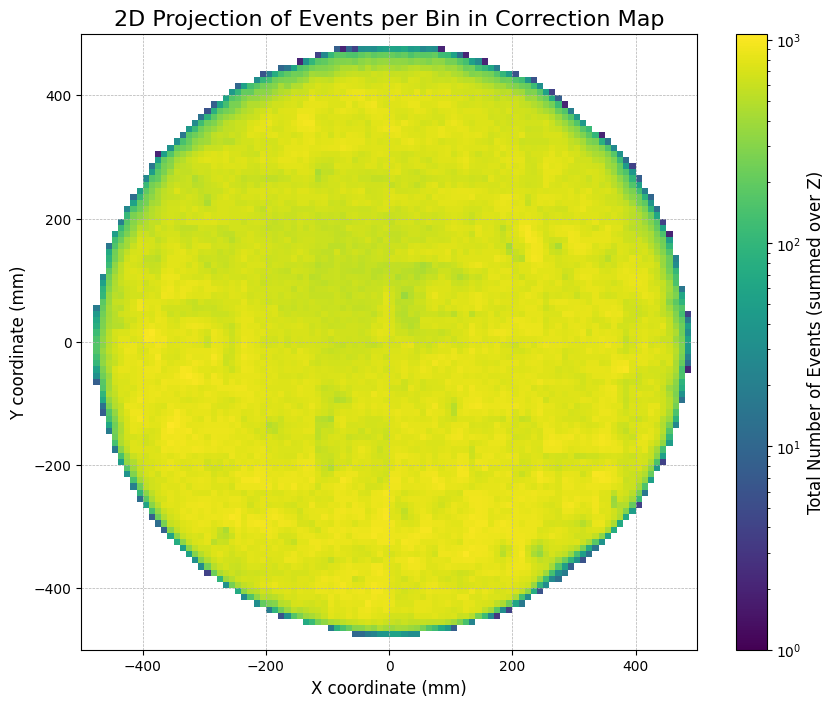

In [36]:
# DEFINE the path to your map file here
map_file_path = "/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/combined_15546_15557.map3d"

# IMPORTANT: You may need to change this column name.
# Look at the printed output of the script to see the available columns in your file
# and replace 'nevents_in_bin' with the correct one (e.g., 'entries', 'counts', etc.)
event_count_column = 'n'

visualize_correction_map(map_file_path, event_count_column)

In [39]:
def visualize_full_map_stats(krmap, events_column_name='n'):
    """
    Generates a 2D plot of the total number of events for the entire map.
    """
    print("--- Generating Plot 1: Full Detector Event Statistics ---")
    
    # Create the 2D XY projection by summing event counts over Z
    xy_events_map = krmap.pivot_table(index='y', columns='x', values=events_column_name, aggfunc='sum')
    
    # Replace zeros with NaN to leave empty bins white
    xy_events_map[xy_events_map == 0] = np.nan

    # --- NEW: Robustly check the data range before plotting ---
    # Use nanmax to safely find the maximum value, ignoring NaNs
    vmax_val = np.nanmax(xy_events_map.values)
    vmin_val = 1  # The minimum for our log scale

    # Check if a valid range for the colorbar exists (vmax must be > vmin)
    if not np.isfinite(vmax_val) or vmax_val <= vmin_val:
        print("\n--- WARNING ---")
        print("Could not generate the event statistics plot.")
        print(f"The maximum number of events in any bin is {vmax_val}, which is not greater than the required minimum of {vmin_val} for the log scale.")
        print("This usually means the map has very low or no statistics. Skipping Plot 1.")
        print("-----------------\n")
        return # Exit the function without plotting

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(11, 9))
    x_coords = xy_events_map.columns.values
    y_coords = xy_events_map.index.values

    # We now use our validated vmax_val
    norm = colors.LogNorm(vmin=vmin_val, vmax=vmax_val)
    c = ax.pcolormesh(x_coords, y_coords, xy_events_map.values,
                      norm=norm, cmap='viridis', shading='auto')

    ax.set_title('Full Map: Total Events per (X,Y) Bin', fontsize=16)
    ax.set_xlabel('X coordinate (mm)', fontsize=12)
    ax.set_ylabel('Y coordinate (mm)', fontsize=12)
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('Total Number of Events (summed over Z)', fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.show()

def visualize_zoomed_correction_factors(krmap, x_range, y_range):
    """
    Generates a zoomed-in plot of a specific region, showing the average
    correction factor with the value printed on each bin.
    """
    print(f"\n--- Generating Plot 2: Zoomed-in Correction Factors ---")
    print(f"Region of Interest: X from {x_range[0]} to {x_range[1]}, Y from {y_range[0]} to {y_range[1]}")

    # 1. Filter the DataFrame to the region of interest
    zoom_df = krmap[(krmap['x'] >= x_range[0]) & (krmap['x'] <= x_range[1]) &
                    (krmap['y'] >= y_range[0]) & (krmap['y'] <= y_range[1])]

    if zoom_df.empty:
        print("No data found in the specified range. Please adjust x_range and y_range. Skipping Plot 2.")
        return

    # 2. Create a 2D map of the AVERAGE correction factor over the Z-axis
    xy_factor_map = zoom_df.pivot_table(index='y', columns='x', values='factor', aggfunc='mean')

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(12, 10))
    x_coords = xy_factor_map.columns.values
    y_coords = xy_factor_map.index.values

    c = ax.pcolormesh(x_coords, y_coords, xy_factor_map.values, cmap='coolwarm', shading='auto', vmin=0.9, vmax=1.1)
    
    # 3. Loop over the data and print the factor value on each bin
    for i, y in enumerate(y_coords):
        for j, x in enumerate(x_coords):
            factor_value = xy_factor_map.iloc[i, j]
            if pd.notna(factor_value): # Only print text for valid numbers
                ax.text(x, y, f"{factor_value:.3f}",
                        ha="center", va="center", color="black", fontsize=10)

    ax.set_title(f'Zoomed Map: Average Correction Factor per (X,Y) Bin', fontsize=16)
    ax.set_xlabel('X coordinate (mm)', fontsize=12)
    ax.set_ylabel('Y coordinate (mm)', fontsize=12)
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('Average Correction Factor (mean over Z)', fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    
    plt.show()

Successfully loaded the correction map.
--- Generating Plot 1: Full Detector Event Statistics ---


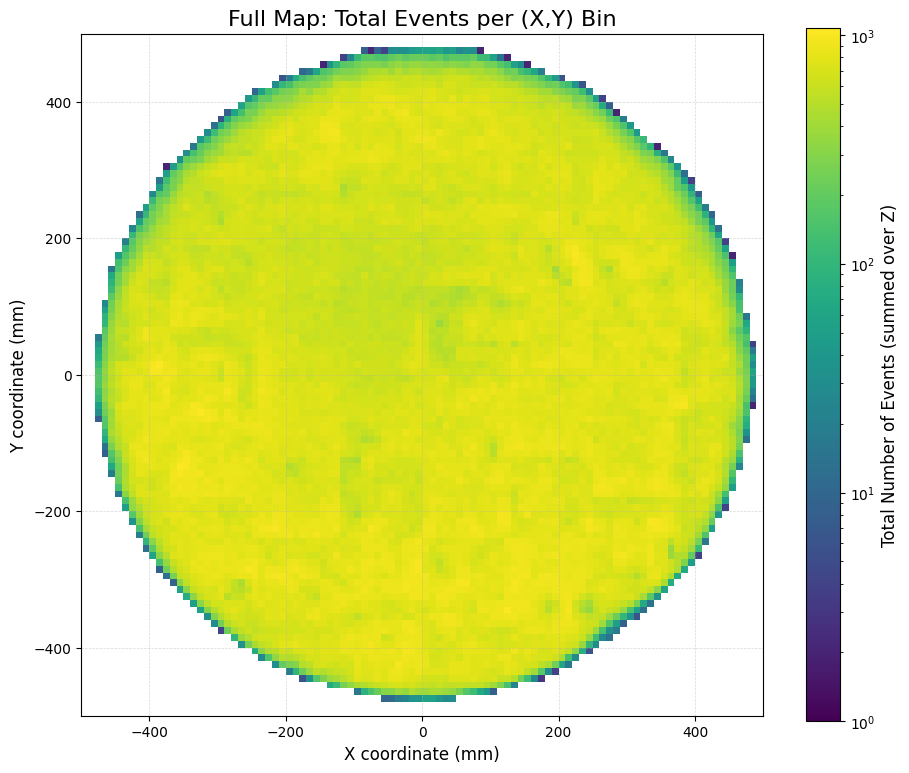


--- Generating Plot 2: Zoomed-in Correction Factors ---
Region of Interest: X from -55 to 55, Y from -55 to 55


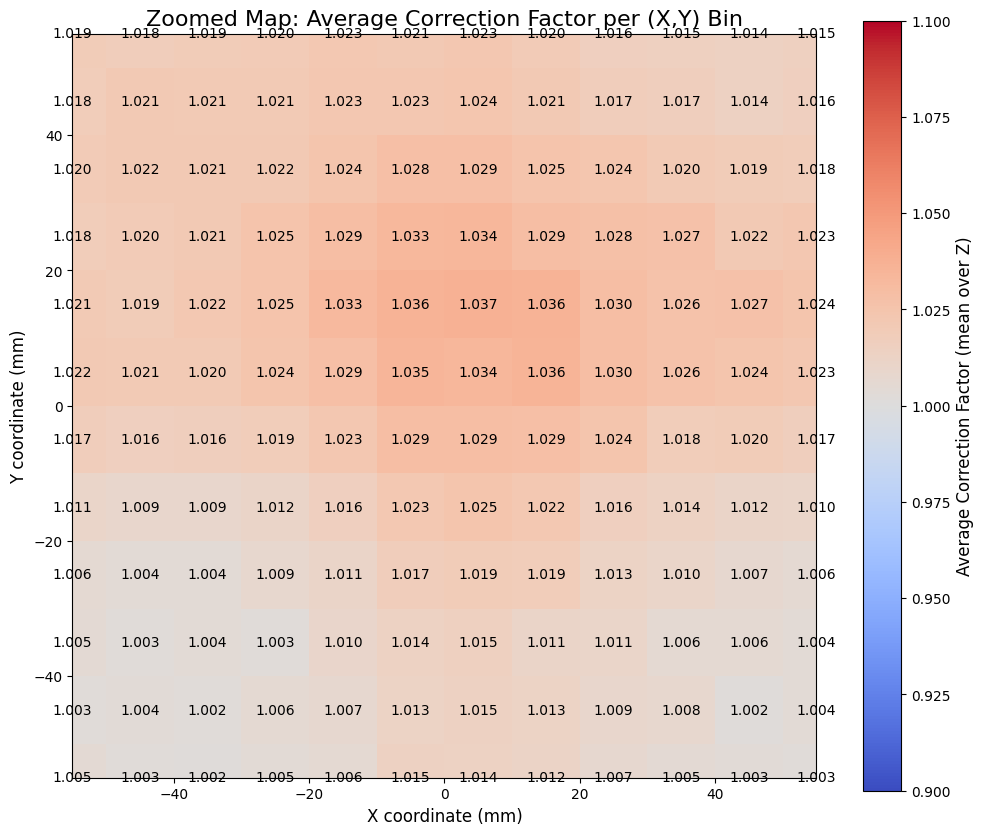

In [40]:
map_file_path = "/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/combined_15546_15557.map3d"
    
try:
    krmap_df = pd.read_hdf(map_file_path, "/krmap")
    print("Successfully loaded the correction map.")
    
    visualize_full_map_stats(krmap_df)

    zoom_x_range = [-55, 55]
    zoom_y_range = [-55, 55]
    
    visualize_zoomed_correction_factors(krmap_df, zoom_x_range, zoom_y_range)

except Exception as e:
    print(f"An error occurred: {e}")

In [41]:
def plot_z_dependence(krmap):
    """
    Plots the average correction factor and total events as a function of Z.
    """
    print("\n--- Generating Plot 3: Correction Factor and Events vs. Z ---")
    
    # Define a central (fiducial) region in XY to average over.
    # This avoids edge effects and gives a cleaner trend.
    # Adjust these values based on your detector's geometry if needed.
    fiducial_range = [-300, 300]
    print(f"Using a central XY region from {fiducial_range[0]}mm to {fiducial_range[1]}mm for averaging.")
    
    # Filter the data to include only the central region
    fiducial_df = krmap[
        (krmap['x'] >= fiducial_range[0]) & (krmap['x'] <= fiducial_range[1]) &
        (krmap['y'] >= fiducial_range[0]) & (krmap['y'] <= fiducial_range[1])
    ]

    if fiducial_df.empty:
        print("No data found in the fiducial region. Cannot generate Z-dependence plot.")
        return

    # Group by the Z coordinate and calculate the mean factor and sum of events
    z_dependence = fiducial_df.groupby('z').agg(
        mean_factor=('factor', 'mean'),
        total_n=('n', 'sum')
    ).reset_index()

    # --- Create the plots ---
    # Create a figure with two subplots stacked vertically, sharing the X-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot 1: Mean Correction Factor vs. Z
    ax1.plot(z_dependence['z'], z_dependence['mean_factor'], 'o-', label='Mean Factor')
    ax1.set_title('Z-Dependence of Correction (Averaged over Central XY)', fontsize=14)
    ax1.set_ylabel('Mean Correction Factor', fontsize=12)
    ax1.grid(True, linestyle='--')
    ax1.legend()

    # Plot 2: Total Events vs. Z
    ax2.plot(z_dependence['z'], z_dependence['total_n'], 'o-', color='C1', label='Total Events')
    ax2.set_xlabel('Z coordinate (mm)', fontsize=12)
    ax2.set_ylabel('Total Events per Z-slice', fontsize=12)
    ax2.grid(True, linestyle='--')
    ax2.legend()
    # Optional: Use a log scale for events if the range is very large
    # ax2.set_yscale('log')

    # Improve layout and show the plot
    plt.tight_layout()
    plt.show()


--- Generating Plot 3: Correction Factor and Events vs. Z ---
Using a central XY region from -300mm to 300mm for averaging.


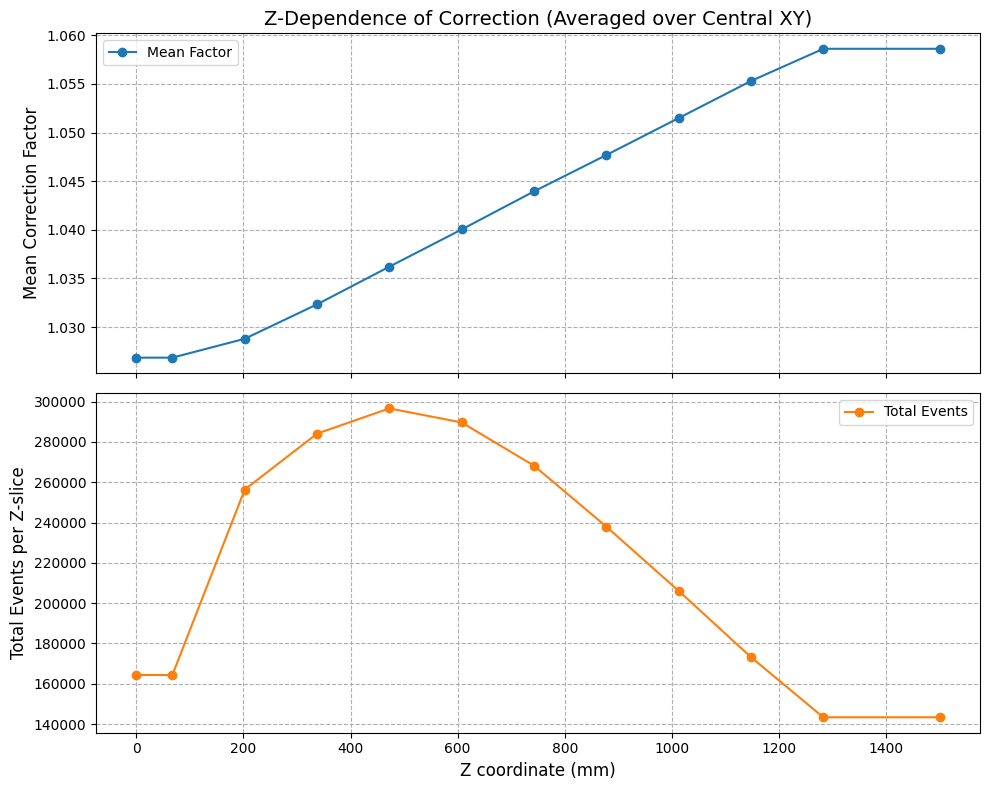

In [42]:
plot_z_dependence(krmap_df)

In [32]:
import pandas as pd
import h5py

def inspect_map_columns(map_file_path):
    """
    Reads the '/krmap' dataset from an HDF5 file and prints its columns.

    Args:
        map_file_path (str): The full path to the .map3d HDF5 file.
    """
    print(f"--- Inspecting file: {map_file_path} ---")

    # --- Method 1: Using pandas (Recommended) ---
    # Pandas is often the easiest way to see the table structure.
    try:
        print("\nAttempting to read with pandas...")
        krmap_df = pd.read_hdf(map_file_path, "/krmap")
        
        print("\nSuccessfully loaded '/krmap' into a pandas DataFrame.")
        print("-------------------------------------------------")
        print("Columns found in '/krmap':")
        # Print each column name on a new line for clarity
        for col in krmap_df.columns:
            print(f"  - {col}")
        print("-------------------------------------------------")

        print("\nHere's a preview of the first 5 rows to see the data:")
        print(krmap_df.head())
        print("-------------------------------------------------\n")

        print("Recommendation:")
        print("Based on the preview, look for a column with integer values that could represent event counts.")
        print("Common names are 'nevents', 'entries', 'counts', 'nevents_in_bin', etc.")

    except Exception as e:
        print(f"\nError reading with pandas: {e}")
        print("This could happen if the file is corrupted or the '/krmap' dataset is not a pandas-compatible table.")

    # --- Method 2: Using h5py (Lower-level) ---
    # If pandas fails, h5py can give us a more raw look at the HDF5 structure.
    try:
        print("\n--- For more detail, inspecting with h5py ---")
        with h5py.File(map_file_path, 'r') as h5file:
            if "/krmap" in h5file:
                krmap_dataset = h5file["/krmap"]
                # For structured arrays, the column names are in the 'dtype'
                if hasattr(krmap_dataset, 'dtype') and krmap_dataset.dtype.names:
                    print("Columns found using h5py:")
                    print(list(krmap_dataset.dtype.names))
                else:
                    print("'/krmap' was found, but it doesn't appear to be a structured table with column names.")
            else:
                print("The dataset '/krmap' was not found in the file.")
            
            # Also list all top-level objects in the file
            print("\nAll top-level objects in the HDF5 file:")
            for key in h5file.keys():
                print(f"  - {key}")

    except Exception as e:
        print(f"\nError reading with h5py: {e}")

In [33]:
map_file_path = f"/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/combined_15546_15557.map3d"
    
inspect_map_columns(map_file_path)

--- Inspecting file: /lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/combined_15546_15557.map3d ---

Attempting to read with pandas...

Successfully loaded '/krmap' into a pandas DataFrame.
-------------------------------------------------
Columns found in '/krmap':
  - z
  - x
  - y
  - level_3
  - factor
  - n
-------------------------------------------------

Here's a preview of the first 5 rows to see the data:
     z      x      y  level_3  factor  n
0  0.0 -495.0 -495.0        0     0.0  0
1  0.0 -495.0 -485.0        0     0.0  0
2  0.0 -495.0 -475.0        0     0.0  0
3  0.0 -495.0 -465.0        0     0.0  0
4  0.0 -495.0 -455.0        0     0.0  0
-------------------------------------------------

Recommendation:
Based on the preview, look for a column with integer values that could represent event counts.
Common names are 'nevents', 'entries', 'counts', 'nevents_in_bin', etc.

--- For more detail, inspecting with h5py ---
'/krmap' was found, but it doesn't ap

In [23]:
full_fil_df.columns

Index(['event', 'time', 'npeak', 'X', 'Y', 'Z', 'Q', 'Ec', 'E_corr',
       'is_isolated', 'E'],
      dtype='object')

In [4]:

from  invisible_cities.reco.corrections     import read_maps, apply_all_correction
from  invisible_cities.types.symbols        import NormStrategy
map_file_path = "/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/15589/map/run_15589.v2.3.1.20250717.Kr.map.h5"
maps = read_maps(map_file_path)

hits_df = full_fil_df.copy()

corr_func = apply_all_correction(maps, apply_temp=False, norm_strat=NormStrategy.kr)
corr_factors = corr_func(hits_df.X, hits_df.Y, hits_df.Z, hits_df.time)

hits_df['E'] = hits_df.E_corr / corr_factors

In [22]:
hits_df.columns

Index(['event', 'time', 'npeak', 'X', 'Y', 'Z', 'Q', 'Ec', 'E_corr',
       'is_isolated', 'E'],
      dtype='object')

In [6]:
hits_df

,event,time,npeak,X,Y,Z,Q,Ec,E_corr,is_isolated,E
0,29,1.751990e+09,39,-189.175,-155.375,701.405875,7.135255,0.000082,0.000081,True,15.901870
1,29,1.751990e+09,39,273.325,198.775,701.405875,7.708335,0.000095,0.000094,True,17.179057
2,29,1.751990e+09,39,381.175,137.575,705.116375,8.119436,0.000147,0.000146,True,25.578989
3,29,1.751990e+09,39,-173.625,-263.225,736.792375,7.477922,0.000125,0.000124,True,23.083329
4,29,1.751990e+09,39,-3.575,-325.425,754.268250,7.946717,0.002437,0.002433,True,450.705870
...,...,...,...,...,...,...,...,...,...,...,...
35991719,3846984,1.752077e+09,29,412.275,-93.675,1039.140500,9.079038,0.000178,0.000177,True,30.557565
35991720,3846984,1.752077e+09,29,273.325,399.925,1043.390375,7.486730,0.000494,0.000265,True,46.389676
35991721,3846984,1.752077e+09,29,427.825,-16.925,1047.366875,7.334613,0.000630,0.000636,True,107.234353
35991722,3846984,1.752077e+09,29,-112.425,322.675,1071.391750,8.449371,0.000543,0.000529,True,97.842388


In [24]:
#sum all the values of 'E' for the event 29 in hits_df
sumita = full_fil_df[ full_fil_df.event == 29 ]['E'].sum()
print(sumita)

284909.99892633874


In [10]:
kdst_key = 'DST/Events'
dffdd = [pd.read_hdf(path, key=kdst_key) for path in kdst_files]
dst_df = pd.concat(dffdd, ignore_index=True)

In [18]:
dst_df[dst_df.event == 29]
#show the value of S2e of this event
dst_df[dst_df.event == 29]['S2e']

0    284933.0
Name: S2e, dtype: float64

In [30]:
map_file_out = "/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/combined_15546_15557.map3d"

#final_map = read_maps(map_file_out)
juju =pd.read_hdf(map_file_out, 'krmap')


In [35]:
juju

,z,x,y,level_3,factor,n
0,0.0,-495.0,-495.0,0,0.0,0
1,0.0,-495.0,-485.0,0,0.0,0
2,0.0,-495.0,-475.0,0,0.0,0
3,0.0,-495.0,-465.0,0,0.0,0
4,0.0,-495.0,-455.0,0,0.0,0
...,...,...,...,...,...,...
119995,1500.0,495.0,455.0,0,0.0,0
119996,1500.0,495.0,465.0,0,0.0,0
119997,1500.0,495.0,475.0,0,0.0,0
119998,1500.0,495.0,485.0,0,0.0,0


In [32]:
jiji =pd.read_hdf(map_file_out, 'mapmeta')

In [33]:
jiji

,rmax,zmax,bin_size_z,bin_size_x,bin_size_y,method,zbins,xbins,ybins,nbins_z,nbins_x,nbins_y,map_shape,map_extent
value,500,1350,135.0,10.0,10.0,fit,"[0.0, 135.0, 270.0, 405.0, 540.0, 675.0, 810.0...","[-500.0, -490.0, -480.0, -470.0, -460.0, -450....","[-500.0, -490.0, -480.0, -470.0, -460.0, -450....",10,100,100,"(10, 100, 100)","[0.0, 1350.0, -500.0, 500.0, -500.0, 500.0]"


In [36]:
escale = "/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE/energy_scale_he.h5"

#final_map = read_maps(map_file_out)
esc =pd.read_hdf(escale)

In [37]:
esc

,time,e0,e0u,run,ts
0,1.752004e+09,8327.540583,1.768917,15589,2025-07-08 21:54:51.353799
1,1.752033e+09,8331.220792,1.740721,15589,2025-07-09 05:55:16.575213
2,1.752062e+09,8333.719801,1.867037,15589,2025-07-09 13:52:52.807308
3,1.752091e+09,8338.045123,1.783262,15590,2025-07-09 21:57:33.918070
4,1.752120e+09,8336.894223,1.740580,15590,2025-07-10 05:56:36.736005
5,1.752149e+09,8335.311080,1.796714,15590,2025-07-10 13:55:43.580667
6,1.752178e+09,8334.216895,1.764021,15591,2025-07-10 22:14:40.568408
7,1.752207e+09,8336.363357,1.832306,15591,2025-07-11 06:15:16.700634
8,1.752236e+09,8334.773218,1.720873,15591,2025-07-11 14:09:05.767880
9,1.752265e+09,8335.080858,1.685661,15592,2025-07-11 22:15:27.184678
